In [1]:
# 2nd-order elastic experiment

In [2]:
import devito as dv
import numpy as np
import matplotlib.pyplot as plt

grid = dv.Grid(shape=(101, 101), extent=(1000., 1000.))

ux = dv.TimeFunction(name='ux', grid=grid, space_order=2, time_order=2)
uy = dv.TimeFunction(name='uy', grid=grid, space_order=2, time_order=2)

# Material parameters
rho = 1.
mu = 0.25
lam = 0.5

# Shorthand
b = 1/rho

In [3]:
from examples.seismic import TimeAxis, RickerSource

c = np.sqrt(b*(lam+2*mu))

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.5 seconds (500 ms)
dt = 0.5*grid.spacing[0]/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.006  # Source peak frequency is 16Hz (0.016 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 500.

In [4]:
rhs_ux = b*(lam+2*mu)*ux.dx2 + b*mu*ux.dy2 + b*(lam+mu)*uy.dxdy
rhs_uy = b*(lam+2*mu)*uy.dy2 + b*mu*uy.dx2 + b*(lam+mu)*ux.dxdy

eq_ux = dv.Eq(ux.forward,
              2*ux - ux.backward
              + dt**2*rhs_ux)

eq_uy = dv.Eq(uy.forward,
              2*uy - uy.backward
              + dt**2*rhs_uy)

In [5]:
src_ux = src.inject(field=ux.forward, expr=src*dt**2)
src_uy = src.inject(field=uy.forward, expr=src*dt**2)

In [6]:
op = dv.Operator([eq_ux, eq_uy] + src_ux + src_uy)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0018890000000000016, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

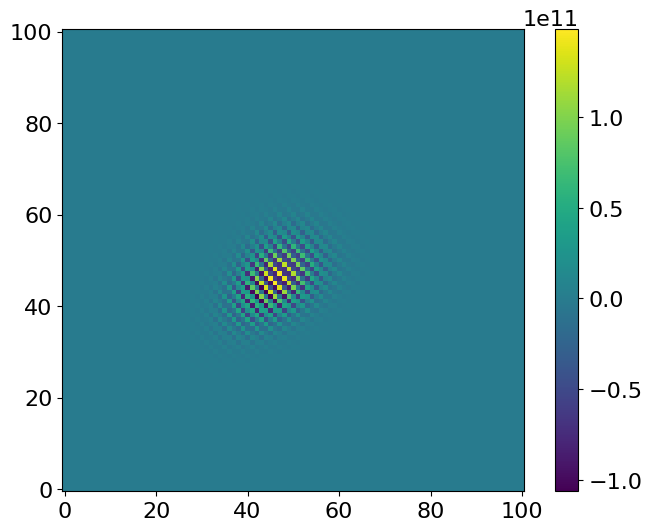

In [7]:
plt.imshow(ux.data[1].T, origin='lower')
plt.colorbar()
plt.show()